# ADNI EDA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import nilearn as nil
import nilearn.plotting

from pathlib import Path
from tqdm.notebook import tqdm

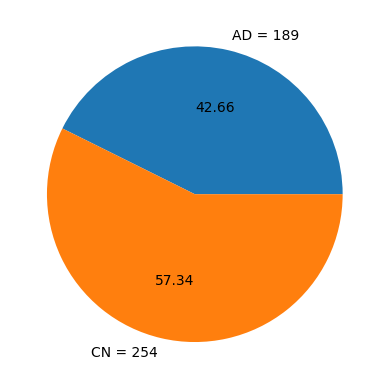

In [2]:
DATA_PATH = Path("../data/adni/")
AD_PATH = DATA_PATH / "AD"
CN_PATH = DATA_PATH / "CN"

ad_samples = list(AD_PATH.glob("*.nii.gz"))
cn_samples = list(CN_PATH.glob("*.nii.gz"))

N_AD = len(list(ad_samples))
N_CN = len(list(cn_samples))

plt.pie([N_AD, N_CN], autopct="%.2f", labels=[f"AD = {N_AD}", f"CN = {N_CN}"]);

In [3]:
ad_img = nib.load(ad_samples[0])
affine = ad_img.affine
print(affine)

[[  -1.5    0.     0.    90. ]
 [   0.     1.5    0.  -126. ]
 [   0.     0.     1.5  -72. ]
 [   0.     0.     0.     1. ]]


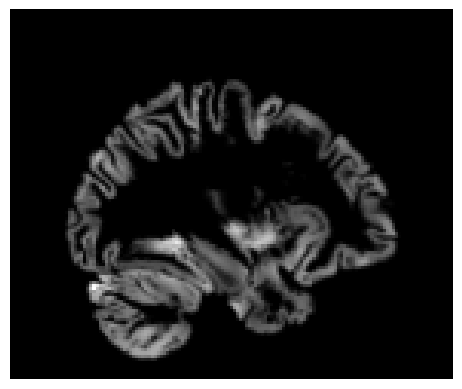

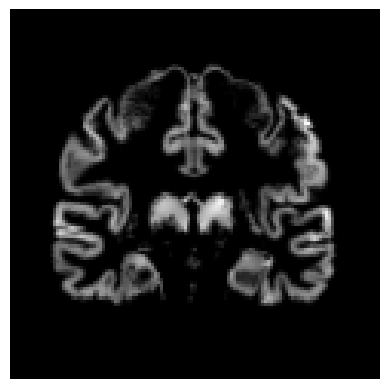

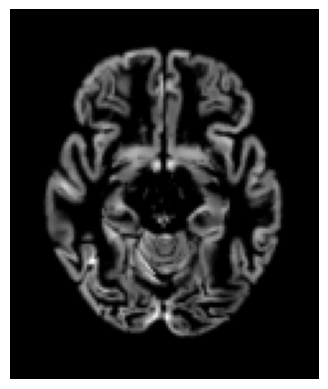

In [4]:
x_ad = ad_img.get_fdata()

xyz = [80, 70, 40]
slice_names = ["sagittal", "coronal", "axial"]

for i in range(3):
    plt.figure()
    im_slice = x_ad.take(xyz[i], axis=i).T
    plt.imshow(im_slice, origin="lower", cmap="binary_r")
    plt.axis("off")
    plt.savefig(f"{slice_names[i]}.png", bbox_inches="tight", pad_inches=0)

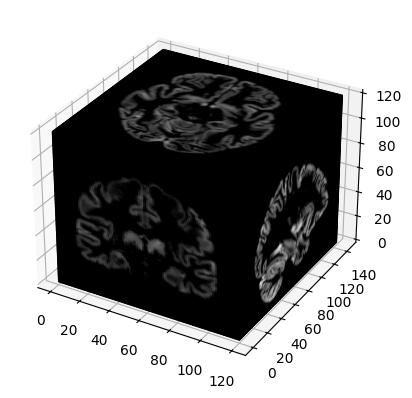

In [5]:
from matplotlib import cm

fig = plt.figure()
ax = plt.axes(projection="3d")

xyz = [80, 70, 40]
xx, yy, zz = np.meshgrid(np.arange(121), np.arange(145), np.arange(121), indexing="ij")

kwargs = dict(antialiased=True, rcount=200, ccount=200)
ax.plot_surface(xx[120,:,:], yy[120,:,:],  zz[120,:,:], facecolors=cm.gray(x_ad[xyz[0],:,:]), **kwargs)
ax.plot_surface(xx[:,0,:], yy[:,0,:], zz[:,0,:], facecolors=cm.gray(x_ad[:,xyz[1],:]), **kwargs)
ax.plot_surface(xx[:,:,120], yy[:,:,120], zz[:,:,120], facecolors=cm.gray(x_ad[:,:,xyz[2]]), **kwargs);

## Mean Brains

In [6]:
def get_mean(samples):
    mu = 0
    for sample in tqdm(samples):
        mu += nib.load(sample).get_fdata()
    return mu / len(samples)


mu_ad = get_mean(ad_samples)
mu_cn = get_mean(cn_samples)

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

In [7]:
def plot_slices(im, xyz, fig=None, axs=None, cmap="binary_r", suptitle="", colorbar=False, alpha=None):
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(12,3))
    if fig is not None:
        fig.suptitle(suptitle)
    for j in range(3):
        slice = im.take(xyz[j], axis=j).T
        slice_alpha = alpha
        if alpha is not None and isinstance(alpha, np.ndarray) and alpha.ndim >= 3:
            slice_alpha = alpha.take(xyz[j], axis=j).T
        im_ax = axs[j].imshow(slice, origin="lower", cmap=cmap, alpha=slice_alpha)
        axs[j].axis(False)
        if colorbar:
            plt.colorbar(im_ax)
    x, y, z = xyz
    axlines = [(y,z), (x,z), (x, y)]
    for j, (a,b) in enumerate(axlines):
        axs[j].axvline(x=a, ls="--")
        axs[j].axhline(y=b, ls="--")
    return axs

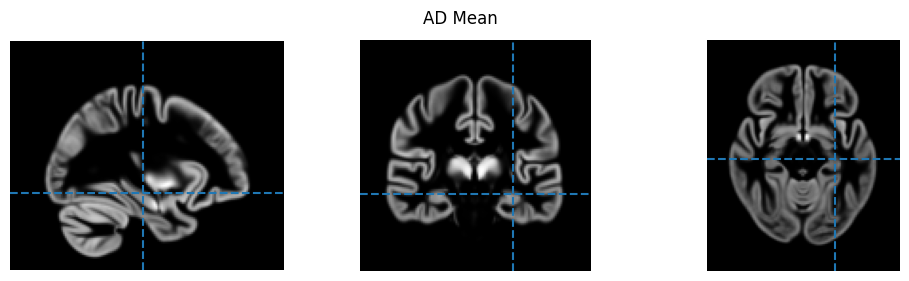

In [8]:
xyz = [80, 70, 40]
plot_slices(mu_ad, xyz, cmap="binary_r", suptitle="AD Mean");

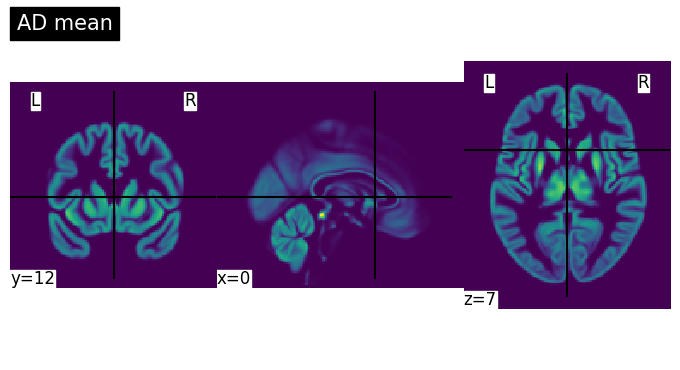

In [9]:
nil.plotting.plot_img(nib.Nifti1Image(mu_ad, affine), title="AD mean")

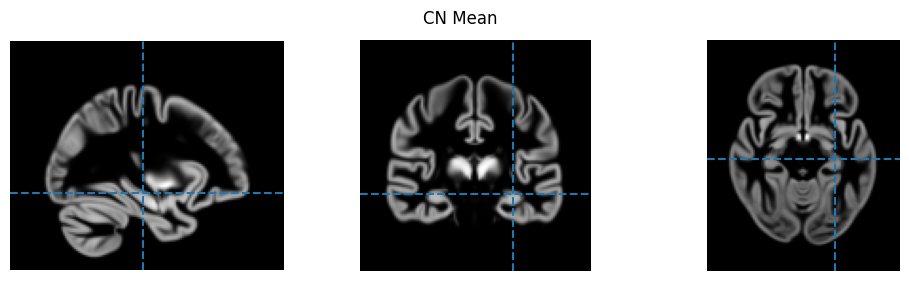

In [10]:
plot_slices(mu_cn, xyz, cmap="binary_r", suptitle="CN Mean");

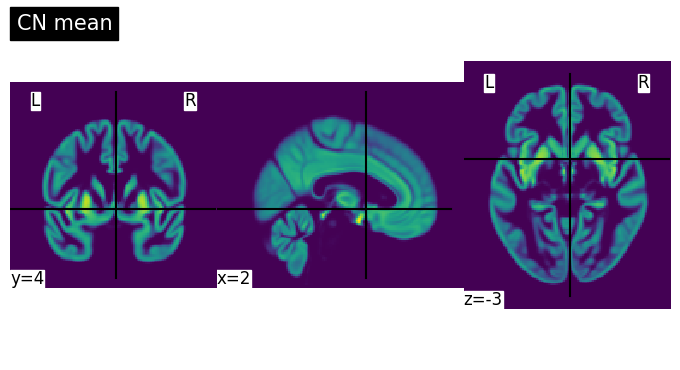

In [11]:
mu_cn_display = nil.plotting.plot_img(nib.Nifti1Image(mu_cn, affine), title="CN mean")

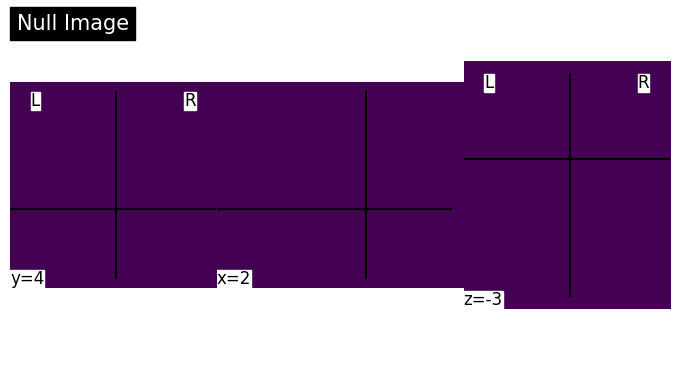

In [12]:
null_img = np.zeros_like(mu_cn)
nil.plotting.plot_img(nib.Nifti1Image(null_img, affine), title="Null Image", cut_coords=mu_cn_display.cut_coords)

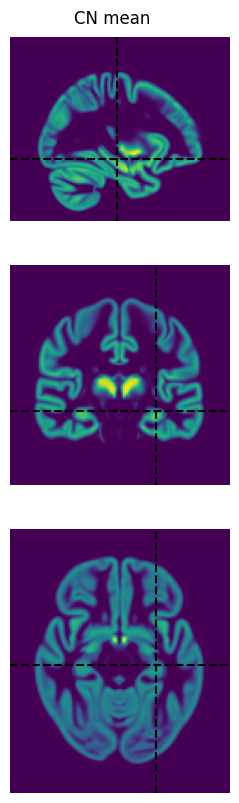

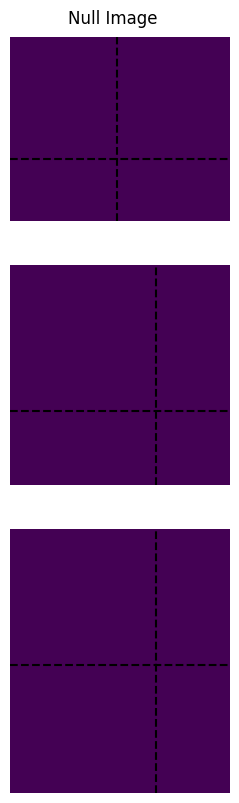

In [13]:

def plot_im_col(im, title=""):
    height_ratios = [121 / 145, 121 / 121, 145/121]
    fig, axs = plt.subplots(3,1, figsize=(6,9), gridspec_kw=dict(height_ratios= height_ratios))

    for i in range(3):
        im_slice = im.take(xyz[i], axis=i).T
        axs[i].imshow(im_slice, origin='lower', aspect="equal")
        axs[i].axis(False)

    x, y, z = xyz
    axlines = [(y,z), (x,z), (x, y)]
    for j, (a,b) in enumerate(axlines):
        axs[j].axvline(x=a, ls="--", color="black")
        axs[j].axhline(y=b, ls="--", color="black")

    fig.suptitle(title)
    plt.subplots_adjust(top=0.95)
    plt.show()

plot_im_col(mu_cn, "CN mean")
plot_im_col(null_img, "Null Image")


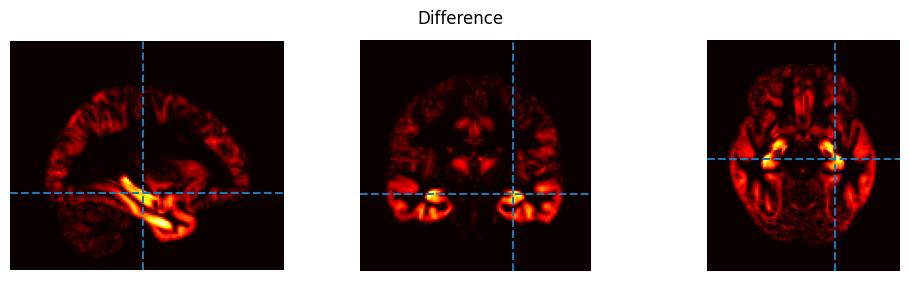

In [14]:
plot_slices(abs(mu_cn - mu_ad), xyz, cmap="hot", suptitle="Difference");

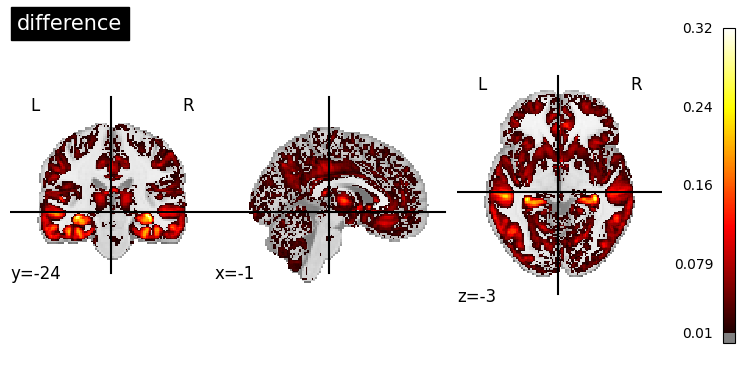

In [15]:
nil.plotting.plot_stat_map(nib.Nifti1Image(abs(mu_cn - mu_ad), affine), threshold=1e-2, title="difference", cmap="hot")

## Voxelwise two-sided Welch's t-Test

In [16]:
def load_samples(samples):
    return np.stack([nib.load(s).get_fdata() for s in tqdm(samples)])

X_ad = load_samples(ad_samples)
X_cn = load_samples(cn_samples)

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

In [17]:
# flatten each sample into a list of voxel values and transpose axes
ad_voxels = X_ad.reshape(X_ad.shape[0], -1).T
print(ad_voxels.shape)

cn_voxels = X_cn.reshape(X_cn.shape[0], -1).T
print(cn_voxels.shape)

(2122945, 189)
(2122945, 254)


In [18]:
from scipy.stats import ttest_ind

# two-sided Welch's t-Test
# Welch's t-Test does not assume equal variances for each voxel within populations AD and CN
ttest_result = ttest_ind(cn_voxels, ad_voxels, axis=1, equal_var=False, alternative="two-sided")

In [19]:
# correction
from statsmodels.stats.multitest import multipletests


# bonferoni correction
# ps_adj = ps * len(ps)
# alpha = 0.01
# significant = (ps_adj <= alpha)

alpha = 0.01

reject, ps_adj, alpha_sidak, alpha_bon = multipletests(ttest_result.pvalue, alpha, method="bonferroni")

In [20]:
# reshape test results back into 3D voxels
ts = ttest_result.statistic.reshape(121, 145, 121)
ps = ttest_result.pvalue.reshape(121, 145, 121)
ps_adj = ps_adj.reshape(121, 145, 121)
reject = reject.reshape(121, 145, 121)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

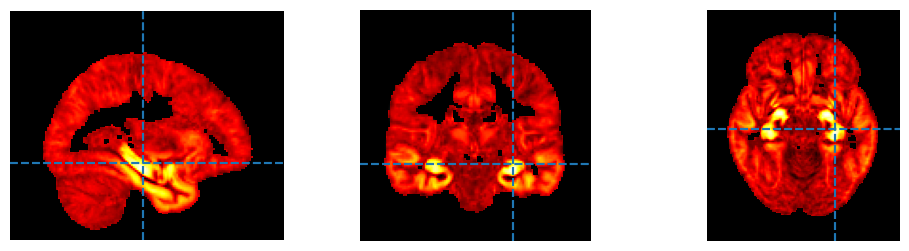

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
plot_slices(mu_ad, xyz, fig=fig, axs=axs)
plot_slices(ts, xyz, cmap="hot", fig=fig, axs=axs)

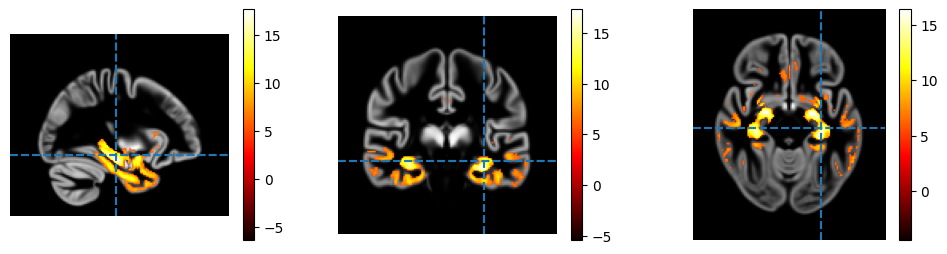

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))

plot_slices(mu_ad, xyz, fig, axs)
plot_slices(ts, xyz, fig, axs, cmap="hot", alpha=reject.astype(np.float64), colorbar=True);

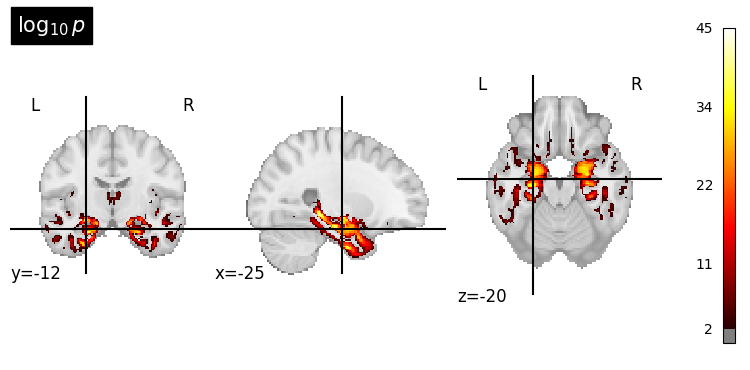

In [23]:
# plot via nilearn
ps_log = -np.log10(ps_adj)
ps_log = np.nan_to_num(ps_log)

p_img = nib.Nifti1Image(ps_log, affine)
nil.plotting.plot_stat_map(p_img, threshold=2, title="$\\log_{10} p$", cmap="hot");

## Atlas

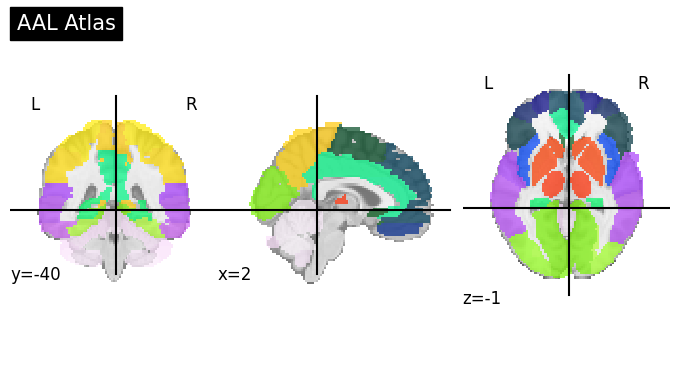

In [24]:
import nilearn as nil

atlas = nil.datasets.fetch_atlas_aal()
nil.plotting.plot_roi(atlas.maps, title="AAL Atlas")

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

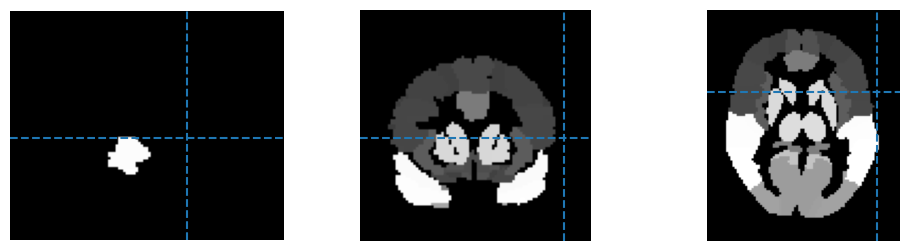

In [25]:
atlas_map = nib.load(atlas.maps).get_fdata()

plot_slices(atlas_map, xyz)

In [26]:
# resample atlas with affine transformation from ADNI data
atlas_map_resampled = nil.image.resample_img(nib.load(atlas.maps), affine, interpolation="nearest")

In [27]:
map_data = atlas_map_resampled.get_fdata()

rois_signi = dict()

for roi, roi_idx in tqdm(zip(atlas["labels"], atlas["indices"])):
    n = np.where(map_data == int(roi_idx), reject, 0).sum()
    roi_signi = dict()
    # roi idx are stored as strings
    roi_signi["size"] = (map_data == int(roi_idx)).sum()
    roi_signi["abs"] = n
    roi_signi["rel"] = n / roi_signi["size"]
    rois_signi[roi] = roi_signi

0it [00:00, ?it/s]

In [28]:
import pandas as pd

roi_df = pd.DataFrame.from_dict(rois_signi, orient="index")
roi_df.head()

,size,abs,rel
Precentral_L,8281,1,0.000121
Precentral_R,7972,0,0.000000
Frontal_Sup_L,8407,0,0.000000
Frontal_Sup_R,9749,0,0.000000
Frontal_Sup_Orb_L,2399,44,0.018341


In [29]:
# top 10 ROIs according to absolute number of significant voxels
roi_df.sort_values("abs", ascending=False).head(10)

,size,abs,rel
Temporal_Inf_L,7562,1784,0.235916
Hippocampus_L,2225,1574,0.707416
Hippocampus_R,2265,1339,0.591170
Temporal_Mid_L,11745,1316,0.112048
ParaHippocampal_R,2675,1268,0.474019
Fusiform_R,5976,1229,0.205656
Fusiform_L,5410,1078,0.199261
Temporal_Inf_R,8339,987,0.118360
ParaHippocampal_L,2330,964,0.413734
Temporal_Mid_R,10556,763,0.072281


In [30]:
# top 10 ROIs according to number of significant voxels relative to ROI size
roi_df.sort_values("rel", ascending=False).head(10)

,size,abs,rel
Amygdala_L,504,402,0.797619
Hippocampus_L,2225,1574,0.707416
Amygdala_R,599,391,0.652755
Hippocampus_R,2265,1339,0.591170
ParaHippocampal_R,2675,1268,0.474019
ParaHippocampal_L,2330,964,0.413734
Temporal_Pole_Mid_L,1789,624,0.348798
Temporal_Inf_L,7562,1784,0.235916
Temporal_Pole_Sup_L,3005,680,0.226290
Temporal_Pole_Mid_R,2786,590,0.211773
